<a href="https://colab.research.google.com/github/SabagYoav/Parallel-Computing/blob/main/Parallel_FIFA_Dataset_clastering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

In [ ]:
# imports of relevant libraies
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col

from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType

from pyspark.ml.linalg import Vectors
from pyspark.sql.types import ArrayType, DoubleType

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import pyspark.sql.functions as f

In [ ]:
#start spark session
spark = SparkSession.builder \
    .appName("Read CSV File") \
    .getOrCreate()

#Reading the dataFIFA file

In [ ]:
#load datafile
df = spark.read.csv("dataFIFA.csv", header=True, inferSchema=True)

In [ ]:
#df visualization
df.show(10)

+---+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+-------+-----+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------------+
|_c0|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Log

In [ ]:
#printing the schema to inspect the tipes of variables we are dilling with
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- Wage: string (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nu

# Feature Engineering Clustering

In [ ]:
# features sellected for clustering
features = [ '_c0','Name', 'Wage','Value', 'Overall', 'Potential','Skill Moves',  'Dribbling', 'BallControl', 'Reactions','Agility','ShotPower', 'Stamina','Vision' , 'SprintSpeed' ,'Release Clause', ]
features_for_corr = [  'Wage','Value', 'Overall', 'Potential','Skill Moves',  'Dribbling', 'BallControl', 'Reactions','Agility','ShotPower', 'Stamina','Vision' , 'SprintSpeed' ,'Release Clause', ]


#df casting from strint to int
df = df.withColumn("Wage", regexp_replace(df["Wage"], "[€K]", ""))# Remove '€' and 'K' from the "Wage" column
df = df.withColumn("Wage", df["Wage"].cast(IntegerType()))# Cast "Wage" column to FloatType
df = df.withColumn('Value',f.regexp_replace('Value','[€M]', '').cast('int'))
df = df.withColumn('Release Clause',f.regexp_replace('Release Clause','[€M]', '').cast('int'))


In [ ]:
#function to convert specified features into the requered type
def convertFeaturesToFloat(df, features, newType):
  for feature in features:
     df = df.withColumn(feature, df[feature].cast(newType))
  return df

df = convertFeaturesToFloat(df, features_for_corr, FloatType())

In [ ]:
#inspecting all featurs to cluster are float values
df[features].printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Wage: float (nullable = true)
 |-- Value: float (nullable = true)
 |-- Overall: float (nullable = true)
 |-- Potential: float (nullable = true)
 |-- Skill Moves: float (nullable = true)
 |-- Dribbling: float (nullable = true)
 |-- BallControl: float (nullable = true)
 |-- Reactions: float (nullable = true)
 |-- Agility: float (nullable = true)
 |-- ShotPower: float (nullable = true)
 |-- Stamina: float (nullable = true)
 |-- Vision: float (nullable = true)
 |-- SprintSpeed: float (nullable = true)
 |-- Release Clause: float (nullable = true)



In [ ]:
#extra import for the heatmap
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import seaborn as sns

<ipython-input-46-4e0336ec0fa1>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = np.abs(corr_df.corr())


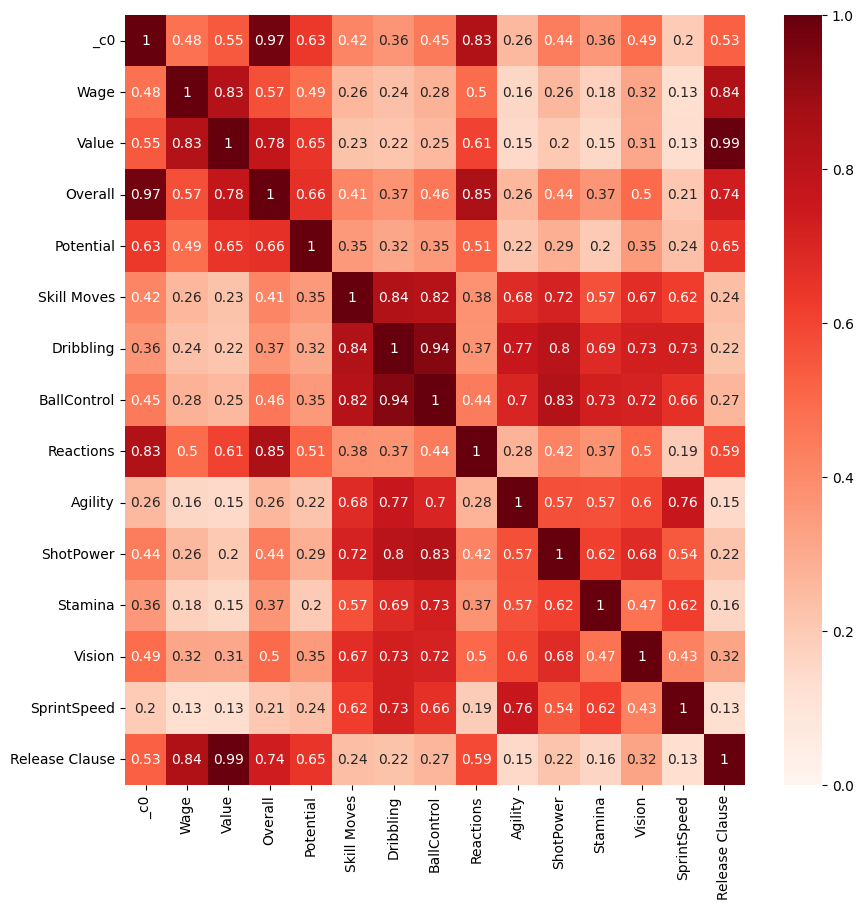

In [ ]:
#calculating th correlation matrix and printing it as heatmap
def calc_and_show_heatmap(df, features):
  plt.figure(figsize=(10,10))
  corr_df = df[features].toPandas()
  corr_matrix = np.abs(corr_df.corr())
  hm = sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds, vmin=0, vmax=1)
  plt.show()
  return corr_matrix

corr_matrix = calc_and_show_heatmap(df, features)


In [ ]:
#caculationg the largest correlated features with Wage
top_5_correlated = corr_matrix.abs().nlargest(6, features_for_corr, keep='first')
top_5_correlated

,_c0,Wage,Value,Overall,Potential,Skill Moves,Dribbling,BallControl,Reactions,Agility,ShotPower,Stamina,Vision,SprintSpeed,Release Clause
Wage,0.479719,1.000000,0.831264,0.571926,0.486413,0.263205,0.237150,0.277615,0.495560,0.156287,0.258351,0.177562,0.315395,0.130315,0.840091
Release Clause,0.526274,0.840091,0.992340,0.737649,0.645569,0.242096,0.224349,0.265895,0.588222,0.149160,0.220239,0.162195,0.321685,0.129182,1.000000
Value,0.545786,0.831264,1.000000,0.778741,0.646960,0.226365,0.217227,0.254437,0.606294,0.151917,0.203436,0.154729,0.310912,0.134188,0.992340
Overall,0.972791,0.571926,0.778741,1.000000,0.660939,0.414463,0.372426,0.460197,0.850045,0.264952,0.441118,0.365656,0.498894,0.210647,0.737649
Reactions,0.832156,0.495560,0.606294,0.850045,0.513425,0.377044,0.369265,0.443750,1.000000,0.275893,0.418361,0.369347,0.502536,0.192402,0.588222
Potential,0.633395,0.486413,0.646960,0.660939,1.000000,0.354290,0.315019,0.354396,0.513425,0.222310,0.288318,0.202563,0.348141,0.236771,0.645569


In [ ]:
df.show(10)

+---+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+-----+-----+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------------+
|_c0|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|

In [ ]:
#inspecting the df with only top correlated to Wage feature selected
TopCorrFeaturs = ['_c0','Name',  'Wage','Value', 'Overall', 'Potential', 'Reactions','Release Clause', ]
Selected_Top_corr_df = df.select(TopCorrFeaturs)
Selected_Top_corr_df.show(10)

+---+-----------------+-----+-----+-------+---------+---------+--------------+
|_c0|             Name| Wage|Value|Overall|Potential|Reactions|Release Clause|
+---+-----------------+-----+-----+-------+---------+---------+--------------+
|  0|         L. Messi|565.0|110.0|   94.0|     94.0|     95.0|         226.0|
|  1|Cristiano Ronaldo|405.0| 77.0|   94.0|     94.0|     96.0|         127.0|
|  2|        Neymar Jr|290.0|118.0|   92.0|     93.0|     94.0|         228.0|
|  3|           De Gea|260.0| 72.0|   91.0|     93.0|     90.0|         138.0|
|  4|     K. De Bruyne|355.0|102.0|   91.0|     92.0|     91.0|         196.0|
|  5|        E. Hazard|340.0| 93.0|   91.0|     91.0|     90.0|         172.0|
|  6|        L. Modrić|420.0| 67.0|   91.0|     91.0|     90.0|         137.0|
|  7|        L. Suárez|455.0| 80.0|   91.0|     91.0|     92.0|         164.0|
|  8|     Sergio Ramos|380.0| 51.0|   91.0|     91.0|     85.0|         104.0|
|  9|         J. Oblak| 94.0| 68.0|   90.0|     93.0

### Data cleaning

In [ ]:
#Droping all nall values
print('number of rows before removing:', df.count())
cleaned_Top_corr_df_with_name = Selected_Top_corr_df.dropna()
print('number of rows after removing:', df.count())

number of rows before removing: 18207
number of rows after removing: 18207


In [ ]:
cleaned_Top_corr_df = cleaned_Top_corr_df_with_name.drop("Name")

In [ ]:
type(cleaned_Top_corr_df)

In [ ]:
cleaned_Top_corr_df.show(10)

+---+-----+-----+-------+---------+---------+--------------+
|_c0| Wage|Value|Overall|Potential|Reactions|Release Clause|
+---+-----+-----+-------+---------+---------+--------------+
|  0|565.0|110.0|   94.0|     94.0|     95.0|         226.0|
|  1|405.0| 77.0|   94.0|     94.0|     96.0|         127.0|
|  2|290.0|118.0|   92.0|     93.0|     94.0|         228.0|
|  3|260.0| 72.0|   91.0|     93.0|     90.0|         138.0|
|  4|355.0|102.0|   91.0|     92.0|     91.0|         196.0|
|  5|340.0| 93.0|   91.0|     91.0|     90.0|         172.0|
|  6|420.0| 67.0|   91.0|     91.0|     90.0|         137.0|
|  7|455.0| 80.0|   91.0|     91.0|     92.0|         164.0|
|  8|380.0| 51.0|   91.0|     91.0|     85.0|         104.0|
|  9| 94.0| 68.0|   90.0|     93.0|     86.0|         144.0|
+---+-----+-----+-------+---------+---------+--------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.linalg import DenseVector

#creating dense vector for k-means
input_data = cleaned_Top_corr_df.rdd.map(lambda x: (x[0], DenseVector(x[1:])))

In [ ]:
# creating a densevector dataframe
new_df = spark.createDataFrame(input_data, ["label", "features"])
new_df.take(3)

[Row(label=0, features=DenseVector([565.0, 110.0, 94.0, 94.0, 95.0, 226.0])),
 Row(label=1, features=DenseVector([405.0, 77.0, 94.0, 94.0, 96.0, 127.0])),
 Row(label=2, features=DenseVector([290.0, 118.0, 92.0, 93.0, 94.0, 228.0]))]

In [ ]:
#inspecting the new created densevector df
new_df.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[565.0,110.0,94.0...|
|    1|[405.0,77.0,94.0,...|
|    2|[290.0,118.0,92.0...|
|    3|[260.0,72.0,91.0,...|
|    4|[355.0,102.0,91.0...|
|    5|[340.0,93.0,91.0,...|
|    6|[420.0,67.0,91.0,...|
|    7|[455.0,80.0,91.0,...|
|    8|[380.0,51.0,91.0,...|
|    9|[94.0,68.0,90.0,9...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.feature import StandardScaler

standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# Fit the DataFrame to the scaler
scaler = standardScaler.fit(new_df)

# Transform the data in `df` with the scaler
scaled_df = scaler.transform(new_df)

# Inspect the result
scaled_df.take(3)

[Row(label=0, features=DenseVector([565.0, 110.0, 94.0, 94.0, 95.0, 226.0]), features_scaled=DenseVector([17.0705, 13.1498, 21.5747, 19.9306, 14.4639, 13.8808])),
 Row(label=1, features=DenseVector([405.0, 77.0, 94.0, 94.0, 96.0, 127.0]), features_scaled=DenseVector([12.2363, 9.2049, 21.5747, 19.9306, 14.6161, 7.8002])),
 Row(label=2, features=DenseVector([290.0, 118.0, 92.0, 93.0, 94.0, 228.0]), features_scaled=DenseVector([8.7618, 14.1062, 21.1157, 19.7186, 14.3116, 14.0036]))]

## K-means clustering from spark ML library

In [ ]:
#extra library requiered for this section
from pyspark.ml.feature import VectorAssembler

In [ ]:
##selecting the features to cluster
feature_clusters = ["Wage", "Value", "Overall", "Potential", "Reactions", "Release Clause"]

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_clusters, outputCol="features")
assembled_data = assembler.transform(cleaned_Top_corr_df_with_name)
assembled_data.show(10)

+---+-----------------+-----+-----+-------+---------+---------+--------------+--------------------+
|_c0|             Name| Wage|Value|Overall|Potential|Reactions|Release Clause|            features|
+---+-----------------+-----+-----+-------+---------+---------+--------------+--------------------+
|  0|         L. Messi|565.0|110.0|   94.0|     94.0|     95.0|         226.0|[565.0,110.0,94.0...|
|  1|Cristiano Ronaldo|405.0| 77.0|   94.0|     94.0|     96.0|         127.0|[405.0,77.0,94.0,...|
|  2|        Neymar Jr|290.0|118.0|   92.0|     93.0|     94.0|         228.0|[290.0,118.0,92.0...|
|  3|           De Gea|260.0| 72.0|   91.0|     93.0|     90.0|         138.0|[260.0,72.0,91.0,...|
|  4|     K. De Bruyne|355.0|102.0|   91.0|     92.0|     91.0|         196.0|[355.0,102.0,91.0...|
|  5|        E. Hazard|340.0| 93.0|   91.0|     91.0|     90.0|         172.0|[340.0,93.0,91.0,...|
|  6|        L. Modrić|420.0| 67.0|   91.0|     91.0|     90.0|         137.0|[420.0,67.0,91.0,...|


Finding the best k value from the silhouette_scores from rang of 15 k values

In [ ]:
silhouette_scores = []
silh = []
xSilh = []

#iterating thue 15 k values
for k in range(2, 15):
    # Train a k-means model
    kmeans = KMeans(featuresCol="features", k=k)
    model = kmeans.fit(assembled_data)
    # predict
    predictions = model.transform(assembled_data)
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append((k, silhouette_score))
    # create xy for the plot
    silh.append(silhouette_score)
    xSilh.append(k)

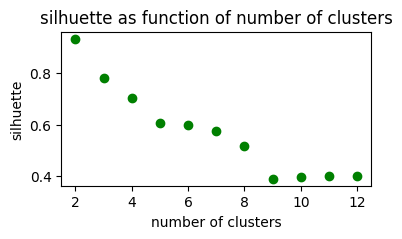

In [ ]:
#ploting the 15 k values
plt.figure(figsize=(4,2))

plt.scatter(xSilh, silh,label='Centers',color='g')
plt.xlabel('number of clusters')
plt.ylabel('silhuette')
plt.title('silhuette as function of number of clusters')

plt.show()

In [ ]:
#inspecting the numerical k values
silhouette_scores

[(2, 0.9343869594613545),
 (3, 0.7831039931234497),
 (4, 0.7023399797191435),
 (5, 0.6074230237225096),
 (6, 0.6008978874445351),
 (7, 0.5746027270647994),
 (8, 0.518076266257797),
 (9, 0.3903558905406678),
 (10, 0.39578020986951035),
 (11, 0.399145497133104),
 (12, 0.4007704899014998)]

In [ ]:
#taking the best silh scotre and k of the best score
max_score = max(silhouette_scores, key=lambda x: x[1])
print("Best score achived for k=", max_score[0], "with silhouette score=", max_score[1])

Best score achived for k= 2 with silhouette score= 0.9343869594613545


Training the kmeans model for max scored K=2

In [ ]:
#training k means for the best score of k=2
kmeans = KMeans(featuresCol="features", k=2)
model = kmeans.fit(assembled_data)
predictions = model.transform(assembled_data)

In [ ]:
predictions.show(20)

+---+-----------------+-----+-----+-------+---------+---------+--------------+--------------------+----------+
|_c0|             Name| Wage|Value|Overall|Potential|Reactions|Release Clause|            features|prediction|
+---+-----------------+-----+-----+-------+---------+---------+--------------+--------------------+----------+
|  0|         L. Messi|565.0|110.0|   94.0|     94.0|     95.0|         226.0|[565.0,110.0,94.0...|         1|
|  1|Cristiano Ronaldo|405.0| 77.0|   94.0|     94.0|     96.0|         127.0|[405.0,77.0,94.0,...|         1|
|  2|        Neymar Jr|290.0|118.0|   92.0|     93.0|     94.0|         228.0|[290.0,118.0,92.0...|         1|
|  3|           De Gea|260.0| 72.0|   91.0|     93.0|     90.0|         138.0|[260.0,72.0,91.0,...|         1|
|  4|     K. De Bruyne|355.0|102.0|   91.0|     92.0|     91.0|         196.0|[355.0,102.0,91.0...|         1|
|  5|        E. Hazard|340.0| 93.0|   91.0|     91.0|     90.0|         172.0|[340.0,93.0,91.0,...|         1|
|

In [ ]:
#Selecting the top 10 players and inspecting their prediction

clustered_df = predictions.select("_c0", "Wage", "prediction")

sorted_clustered_df = clustered_df.orderBy(clustered_df["Wage"].desc())

sorted_clustered_df.show(10)

+---+-----+----------+
|_c0| Wage|prediction|
+---+-----+----------+
|  0|565.0|         1|
|  7|455.0|         1|
|  6|420.0|         1|
|  1|405.0|         1|
|  8|380.0|         1|
| 11|355.0|         1|
|  4|355.0|         1|
| 36|355.0|         1|
|  5|340.0|         1|
| 32|340.0|         1|
+---+-----+----------+
only showing top 10 rows



As we can see from the table, all top 10 Wage palyers belong to the same cluster for k=2 clusters

## Dimentionality reduction using PCA

In [ ]:
from pyspark.ml.feature import PCA

In [ ]:
#function to reduce the dimention of dataset to n_components using pca
def dim_reduced_pca(data, n_components):
  print('num_pca_components=', n_components)
  pca = PCA(k=n_components, inputCol="features", outputCol="pcaFeatures")
  model = pca.fit(data)

  data_reduced_pca = model.transform(data).select("_c0","Name","Wage", "pcaFeatures")
  print('result_pca df:')
  data_reduced_pca.show(10)
  return data_reduced_pca

In [ ]:
#function to fit kmeans model over ginven df for a given number of clusters
def kmeans_for_pca(df, cluster_num):
  kmeans = KMeans(featuresCol="pcaFeatures", k=cluster_num)
  model = kmeans.fit(data_reduced_pca)
  predictions = model.transform(data_reduced_pca)
  # Select the column containing the names and the cluster prediction column
  clustered_df = predictions.select("_c0", "Name", "Wage", "prediction")
  # Arrange by Wage in descending order
  sorted_clustered_df = clustered_df.orderBy(clustered_df["Wage"].desc())
  # Show the resulting DataFrame
  print('df with prediction sorted by wage:')
  sorted_clustered_df.show(10)
  return sorted_clustered_df , model.clusterCenters()
  print('---------------------------------------------------   \n')

In [ ]:
#iterating thure 5 clusters number and inspecting the top 10 players clusters
for n in range(2, 6):
  data_reduced_pca = dim_reduced_pca(assembled_data, n)
  clustered_df, centers = kmeans_for_pca(data_reduced_pca, 2)

num_pca_components= 2
result_pca df:
+---+-----------------+-----+--------------------+
|_c0|             Name| Wage|         pcaFeatures|
+---+-----------------+-----+--------------------+
|  0|         L. Messi|565.0|[-635.42252087048...|
|  1|Cristiano Ronaldo|405.0|[-448.63490712496...|
|  2|        Neymar Jr|290.0|[-394.53572278861...|
|  3|           De Gea|260.0|[-322.87291813204...|
|  4|     K. De Bruyne|355.0|[-435.67474248490...|
|  5|        E. Hazard|340.0|[-411.00028418361...|
|  6|        L. Modrić|420.0|[-462.66484575963...|
|  7|        L. Suárez|455.0|[-507.02752720325...|
|  8|     Sergio Ramos|380.0|[-410.60599997984...|
|  9|         J. Oblak| 94.0|[-177.26201798523...|
+---+-----------------+-----+--------------------+
only showing top 10 rows

df with prediction sorted by wage:
+---+-----------------+-----+----------+
|_c0|             Name| Wage|prediction|
+---+-----------------+-----+----------+
|  0|         L. Messi|565.0|         1|
|  7|        L. Suárez|4

The results remains the same, all top 10 players apears at the same 1 claster for 3,4,5 dimentions

## Performing dim reduction and ploting 2D

In [ ]:
#sending values to the function to create a new df contains 2 clusters and 2 dims
data_reduced_pca = dim_reduced_pca(assembled_data, 2)
kmeans_for_pca, centers = kmeans_for_pca(data_reduced_pca, 2)

num_pca_components= 2
result_pca df:
+---+-----------------+-----+--------------------+
|_c0|             Name| Wage|         pcaFeatures|
+---+-----------------+-----+--------------------+
|  0|         L. Messi|565.0|[-635.42252087048...|
|  1|Cristiano Ronaldo|405.0|[-448.63490712496...|
|  2|        Neymar Jr|290.0|[-394.53572278861...|
|  3|           De Gea|260.0|[-322.87291813204...|
|  4|     K. De Bruyne|355.0|[-435.67474248490...|
|  5|        E. Hazard|340.0|[-411.00028418361...|
|  6|        L. Modrić|420.0|[-462.66484575963...|
|  7|        L. Suárez|455.0|[-507.02752720325...|
|  8|     Sergio Ramos|380.0|[-410.60599997984...|
|  9|         J. Oblak| 94.0|[-177.26201798523...|
+---+-----------------+-----+--------------------+
only showing top 10 rows

df with prediction sorted by wage:
+---+-----------------+-----+----------+
|_c0|             Name| Wage|prediction|
+---+-----------------+-----+----------+
|  0|         L. Messi|565.0|         1|
|  7|        L. Suárez|4

In [ ]:
# taking the centers of the clusters from the model
xCenter = []
yCenter = []


print("Cluster Centers: ")
for center in centers:
    xCenter.append(center[0])
    yCenter.append(center[1])
print("xCenter: ", xCenter)
print("yCenter: ", yCenter)

Cluster Centers: 
xCenter:  [-37.60706187470458, -178.946987560178]
yCenter:  [-41.87445385247353, -40.45997984787421]


In [ ]:
#creatint a new df contains the data ready to plot as 2d
plot_df = data_reduced_pca.toPandas()
plot_df2 = kmeans_for_pca.toPandas()
plot_df["prediction"] = plot_df2["prediction"]

In [ ]:
# taking the x, y values from the 2 features created by pca dim reduction
pandas_predictions = predictions.toPandas()
xy_1 = plot_df.groupby('prediction').apply(lambda x: x[x['prediction'] == 1])
xy_0 = plot_df.groupby('prediction').apply(lambda x: x[x['prediction'] == 0])

In [ ]:
# creating a new list with the values of x,y for cluster 1
x1=xy_1['pcaFeatures'].apply(lambda cell: cell[0])
y1=xy_1['pcaFeatures'].apply(lambda cell: cell[1])
# creating a new list with the values of x,y for cluster 0
x0=xy_0['pcaFeatures'].apply(lambda cell: cell[0])
y0=xy_0['pcaFeatures'].apply(lambda cell: cell[1])

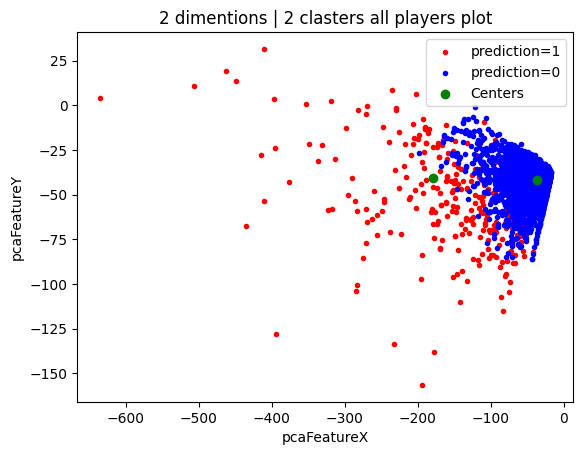

In [ ]:
# scatter plot
  # ploting scaters of predicted cluster 1
plt.scatter(x1, y1,label='prediction=1', marker='.', color='r')
  # ploting scaters of predicted cluster 0
plt.scatter(x0, y0,label='prediction=0',marker='.', color='b')
# plot the centers of the clusters
plt.scatter(xCenter, yCenter, label='Centers',color='g')

plt.xlabel('pcaFeatureX')
plt.ylabel('pcaFeatureY')
plt.title('2 dimentions | 2 clasters all players plot')
plt.legend()

plt.show()